1. weather 전처리 
2. flow & weather merge
3. sliding window
4. train / val / test
5. 정규화 (train만) ,  y는 value scaler로 정규화
6. LSTM

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

0. 데이터 Load

In [2]:
# 파일 로드
# df_flow로 flow data 가져오기 .copy() 사용
BASE_DIR = Path.cwd().parent
df_flow = pd.read_csv(BASE_DIR / "data" / "processed" / "flow_preprocessed.csv", parse_dates=["time"]).copy()

# weather 파일 Load
weather_file = BASE_DIR / "data" / "rawdata" / "weather"
weather = pd.read_csv(weather_file / "SYNOP_AWOS_5153_MI_2023-01_2023-01_2023.csv", encoding="euc-kr")

- 데이터 인코딩

In [3]:
def read_weather_csv(f):
    for enc in ["euc-kr", "cp949", "utf-8", "utf-8-sig"]:
        try:
            return pd.read_csv(f, encoding=enc)
        except (UnicodeDecodeError, UnicodeError):
            continue
    # 모든 인코딩 실패 시 에러 파일 확인용
    raise ValueError(f"인코딩 실패: {f.name}")

# Exclude previously saved total file from glob to prevent duplicated rows
files = sorted(f for f in weather_file.glob("*.csv") if "total" not in f.name)
print(f"읽을 파일 수: {len(files)}")

weather = pd.concat(
    [read_weather_csv(f) for f in files],
    ignore_index=True
)
print(f"concat 후 행 수: {len(weather):,}")

읽을 파일 수: 22
concat 후 행 수: 942,510


- 데이터 저장

In [4]:
weather.to_csv(weather_file / "weather_total_raw.csv", index=False, encoding="utf-8-sig")

1. weather 전처리

In [5]:
weather['일시'] = pd.to_datetime(weather['일시'])

# Fill missing rainfall with 0, interpolate temp/humidity (CoW-compatible, no inplace)
weather['0.5mm 일 누적 강수량(mm)'] = weather['0.5mm 일 누적 강수량(mm)'].fillna(0)
weather['기온(℃)'] = weather['기온(℃)'].interpolate(method='linear', limit=60)
weather['상대습도(%)'] = weather['상대습도(%)'].interpolate(method='linear', limit=60)

# Drop rows with long-gap NaN (>60min) to prevent LSTM from learning fake patterns
before = len(weather)
weather = weather.dropna(subset=['기온(℃)', '상대습도(%)'])
print(f'장기 결측 제거: {before:,} -> {len(weather):,} ({len(weather)/before*100:.1f}% 유지)')

weather = weather.rename(columns={
    '일시': 'datetime',
    '기온(℃)': 'temperature',
    '0.5mm 일 누적 강수량(mm)': 'rainfall',
    '상대습도(%)': 'humidity',
})

# Keep first row on duplicate timestamps
weather = weather.drop_duplicates(subset='datetime', keep='first')
weather = weather.sort_values('datetime').reset_index(drop=True)

# Mark time-discontinuity boundaries for segment-aware sliding window
time_diff = weather['datetime'].diff()
seg_boundary = time_diff > pd.Timedelta(minutes=1)
weather['segment_id'] = seg_boundary.cumsum()
print(f'연속 세그먼트 수: {weather["segment_id"].nunique()}')

print(weather.shape)
print(weather.head())

장기 결측 제거: 942,510 -> 894,039 (94.9% 유지)
연속 세그먼트 수: 3564
(894039, 5)
             datetime  temperature  rainfall  humidity  segment_id
0 2023-01-01 00:01:00         -3.3       0.0      91.6           0
1 2023-01-01 00:02:00         -3.3       0.0      91.6           0
2 2023-01-01 00:03:00         -3.3       0.0      91.6           0
3 2023-01-01 00:04:00         -3.2       0.0      91.6           0
4 2023-01-01 00:05:00         -3.2       0.0      91.6           0


In [6]:
weather.describe()

,datetime,temperature,rainfall,humidity,segment_id
count,894039,894039.000000,894039.000000,894039.000000,894039.000000
mean,2023-12-09 07:18:45.749011,15.358957,1.922265,71.807508,1596.019969
min,2023-01-01 00:01:00,-16.500000,0.000000,2.900000,0.000000
25%,2023-07-03 09:58:30,6.300000,0.000000,57.200000,465.000000
50%,2023-12-13 20:09:00,16.500000,0.000000,76.000000,1066.000000
75%,2024-05-25 11:14:30,24.700000,0.000000,90.300000,3267.000000
max,2024-11-01 00:00:00,37.700000,160.000000,99.900000,3563.000000
std,NaN,10.908432,8.737307,21.188111,1320.075920


In [7]:
df = pd.DataFrame(weather)
df.isnull().sum()

datetime       0
temperature    0
rainfall       0
humidity       0
segment_id     0
dtype: int64

In [10]:
df_log = np.log1p(df["rainfall"])
# df['rainfall'].describe(), df_log.describe()
df['rainfall'] = df_log.copy()
df_weather = df[['datetime', 'temperature', 'rainfall', 'humidity', 'segment_id']].copy()

2-1. weather data merge
2-2. weather, time feature 추가

In [11]:
# 타입 변환 (잘못된 형식은 NaT로 변환 후 제거)
df_flow['time'] = pd.to_datetime(df_flow['time'], errors='coerce')
df_flow = df_flow.dropna(subset=['time'])
print(f"df_flow 정리 후: {len(df_flow):,}개")

df_merged = pd.merge(df_flow, df_weather, how='inner', left_on='time', right_on="datetime")

df_flow 정리 후: 943,434개


In [12]:
df_merged = df_merged.drop(columns=['datetime'])

# 1분 단위 유지 (리샘플링 없음)
df_merged = df_merged.sort_values('time').reset_index(drop=True)
df_merged = df_merged.dropna()
print(f"데이터: {len(df_merged):,}개 (1분 단위)")
# ★ merge 후 시간 불연속 경계 재계산 (weather segment_id 대체)
# weather의 segment_id는 weather 단독 기준이므로,
# flow+weather inner merge 후 실제 불연속을 반영해야 정확함
time_diff_merged = df_merged['time'].diff()
seg_boundary_merged = time_diff_merged > pd.Timedelta(minutes=1)
df_merged['segment_id'] = seg_boundary_merged.cumsum()
print(f"merge 후 연속 세그먼트 수: {df_merged['segment_id'].nunique()}")

# Cyclical temporal features
t: pd.Series = df_merged['time']

# int -> float cast for arithmetic with np.pi
hour = t.dt.hour.astype(np.float64)
minute = t.dt.minute.astype(np.float64)
dow = t.dt.dayofweek.astype(np.float64)
doy = t.dt.dayofyear.astype(np.float64)

# 시간정보 (분 단위 하루 주기, T=1440)
minute_of_day = hour * 60 + minute
df_merged['time_sin'] = 0.5 * np.sin(2 * np.pi * minute_of_day / 1440) + 0.5
df_merged['time_cos'] = 0.5 * np.cos(2 * np.pi * minute_of_day / 1440) + 0.5

# 요일 (주간 주기, T=7)
df_merged['dow_sin'] = 0.5 * np.sin(2 * np.pi * dow / 7) + 0.5
df_merged['dow_cos'] = 0.5 * np.cos(2 * np.pi * dow / 7) + 0.5

# 계절 (연간 주기, T=365.25)
df_merged['season_sin'] = 0.5 * np.sin(2 * np.pi * doy / 365.25) + 0.5
df_merged['season_cos'] = 0.5 * np.cos(2 * np.pi * doy / 365.25) + 0.5

print(f"Temporal features 추가 완료: {df_merged.shape}")
print(df_merged.head())

데이터: 872,723개 (1분 단위)
merge 후 연속 세그먼트 수: 4158
Temporal features 추가 완료: (872723, 12)
                 time      value  temperature  rainfall  humidity  segment_id  \
0 2023-01-01 00:01:00  96.577302         -3.3       0.0      91.6           0   
1 2023-01-01 00:02:00  96.739744         -3.3       0.0      91.6           0   
2 2023-01-01 00:03:00  96.895855         -3.3       0.0      91.6           0   
3 2023-01-01 00:04:00  97.045636         -3.2       0.0      91.6           0   
4 2023-01-01 00:05:00  97.189086         -3.2       0.0      91.6           0   

   time_sin  time_cos   dow_sin   dow_cos  season_sin  season_cos  
0  0.502182  0.999995  0.109084  0.811745    0.508601    0.999926  
1  0.504363  0.999981  0.109084  0.811745    0.508601    0.999926  
2  0.506545  0.999957  0.109084  0.811745    0.508601    0.999926  
3  0.508726  0.999924  0.109084  0.811745    0.508601    0.999926  
4  0.510907  0.999881  0.109084  0.811745    0.508601    0.999926  


In [13]:
df_merged.shape, df_merged.info(), df_merged.describe()

<class 'pandas.DataFrame'>
RangeIndex: 872723 entries, 0 to 872722
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         872723 non-null  datetime64[us]
 1   value        872723 non-null  float64       
 2   temperature  872723 non-null  float64       
 3   rainfall     872723 non-null  float64       
 4   humidity     872723 non-null  float64       
 5   segment_id   872723 non-null  int64         
 6   time_sin     872723 non-null  float64       
 7   time_cos     872723 non-null  float64       
 8   dow_sin      872723 non-null  float64       
 9   dow_cos      872723 non-null  float64       
 10  season_sin   872723 non-null  float64       
 11  season_cos   872723 non-null  float64       
dtypes: datetime64[us](1), float64(10), int64(1)
memory usage: 79.9 MB


((872723, 12),
 None,
                              time          value    temperature  \
 count                      872723  872723.000000  872723.000000   
 mean   2023-12-01 18:39:20.141650     151.786570      15.354982   
 min           2023-01-01 00:01:00       0.000000     -16.500000   
 25%           2023-06-27 11:00:30     109.030874       6.100000   
 50%           2023-12-06 15:46:00     144.881767      16.500000   
 75%           2024-05-14 15:26:30     192.717293      24.800000   
 max           2024-10-17 17:19:00     325.516638      37.700000   
 std                           NaN      56.898401      11.013743   
 
             rainfall       humidity     segment_id       time_sin  \
 count  872723.000000  872723.000000  872723.000000  872723.000000   
 mean        0.343209      71.595445    1853.432576       0.500568   
 min         0.000000       2.900000       0.000000       0.000000   
 25%         0.000000      56.900000     613.000000       0.146447   
 50%         0

In [14]:
# 2-3. Seasonal Block Sampling (45 days × 4 seasons = ~180 days)
# All seasons equally represented for season_sin/cos learning

season_ranges = [
    ('2023-12-01', '2024-01-14', 'Winter'),
    ('2023-04-01', '2023-05-15', 'Spring'),
    ('2023-07-01', '2023-08-14', 'Summer'),
    ('2023-10-01', '2023-11-14', 'Fall'),
]

blocks = []
for i, (start, end, name) in enumerate(season_ranges):
    mask = (df_merged['time'] >= start) & (df_merged['time'] <= end)
    block = df_merged[mask].copy()
    block['block_id'] = i
    blocks.append(block)
    print(f"[{name}] {start} ~ {end}: {len(block):,} rows")

df_merged = pd.concat(blocks, ignore_index=True)
print(f"\nTotal: {len(df_merged):,} rows (4-season block sampling)")


[Winter] 2023-12-01 ~ 2024-01-14: 59,365 rows
[Spring] 2023-04-01 ~ 2023-05-15: 47,285 rows
[Summer] 2023-07-01 ~ 2023-08-14: 63,291 rows
[Fall] 2023-10-01 ~ 2023-11-14: 58,884 rows

Total: 228,825 rows (4-season block sampling)


3. Sliding Windows 생성
- X: (n_samples, input_time, 10) — value, temperature, rainfall, humidity + 6 cyclical features
- y: (n_samples, output_time) — value만 예측

In [15]:
feature_cols = ['value', 'temperature', 'rainfall', 'humidity',
                'time_sin', 'time_cos', 'dow_sin', 'dow_cos',
                'season_sin', 'season_cos']
scale_cols = ['value', 'temperature', 'rainfall', 'humidity']  # MinMaxScaler target (sin/cos excluded)
target_col = 'value'
input_time = 72    # 72 steps × 1min = 72min
output_time = 15   # 15 steps × 1min = 15min (× 4 rolling = 1h)

print(f"=== Settings ===")
print(f"Input: {input_time} steps ({input_time}min = {input_time/60:.1f}h), {len(feature_cols)} features")
print(f"Output: {output_time} steps ({output_time}min) × 4 rolling = {output_time*4}min")


=== Settings ===
Input: 72 steps (72min = 1.2h), 10 features
Output: 15 steps (15min) × 4 rolling = 60min


4. Train / Val / Test Split (0.7 / 0.15 / 0.15)

In [16]:
# Segment-aware sliding window: per-block generation + per-block train/val/test split
# ★ 수정: segment_id 경계를 넘는 window 생성 방지
# Each seasonal block independently split to ensure all seasons in every set

train_ratio, val_ratio = 0.7, 0.15
min_segment_len = input_time + output_time  # 세그먼트 최소 길이

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []
test_times_list = []

skipped_segments = 0
used_segments = 0

for block_id in sorted(df_merged['block_id'].unique()):
    block = df_merged[df_merged['block_id'] == block_id]

    # ★ block 내 segment별로 sliding window 생성
    seg_X, seg_y, seg_times = [], [], []

    for seg_id in sorted(block['segment_id'].unique()):
        segment = block[block['segment_id'] == seg_id].reset_index(drop=True)

        if len(segment) < min_segment_len:
            skipped_segments += 1
            continue  # 너무 짧은 세그먼트 스킵

        used_segments += 1
        seg_features = segment[feature_cols].values.astype(np.float32)
        seg_target = segment[target_col].values.astype(np.float32)
        seg_time = segment['time'].values

        n_samples = len(segment) - input_time - output_time + 1
        for i in range(n_samples):
            seg_X.append(seg_features[i : i + input_time])
            seg_y.append(seg_target[i + input_time : i + input_time + output_time])
            seg_times.append(seg_time[i + input_time])

    if len(seg_X) == 0:
        print(f"Block {block_id}: 유효 윈도우 없음 (스킵)")
        continue

    X_block = np.array(seg_X)
    y_block = np.array(seg_y)
    times_block = np.array(seg_times)
    n_samples = len(X_block)

    t_idx = int(n_samples * train_ratio)
    v_idx = int(n_samples * (train_ratio + val_ratio))

    X_train_list.append(X_block[:t_idx])
    y_train_list.append(y_block[:t_idx])
    X_val_list.append(X_block[t_idx:v_idx])
    y_val_list.append(y_block[t_idx:v_idx])
    X_test_list.append(X_block[v_idx:])
    y_test_list.append(y_block[v_idx:])

    # Collect test timestamps for visualization
    for i in range(v_idx, n_samples):
        test_times_list.append(times_block[i])

    print(f"Block {block_id}: {n_samples:,} samples "
          f"(train={t_idx:,} / val={v_idx-t_idx:,} / test={n_samples-v_idx:,})")

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)
test_times = np.array(test_times_list)

n_total = len(X_train) + len(X_val) + len(X_test)
print(f"\n=== Sliding Window + Split (Seasonal Blocks × Segments) ===")
print(f"★ Segment-aware: {used_segments}개 세그먼트 사용, {skipped_segments}개 스킵 (< {min_segment_len} steps)")
print(f"X shape: ({input_time}, {len(feature_cols)}), y shape: ({output_time},)")
print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,} | Total: {n_total:,}")
print(f"Memory: X_train {X_train.nbytes/1e6:.1f} MB, y_train {y_train.nbytes/1e6:.1f} MB")

Block 0: 28,315 samples (train=19,820 / val=4,247 / test=4,248)
Block 1: 39,513 samples (train=27,659 / val=5,927 / test=5,927)
Block 2: 58,557 samples (train=40,989 / val=8,784 / test=8,784)
Block 3: 49,206 samples (train=34,444 / val=7,381 / test=7,381)

=== Sliding Window + Split (Seasonal Blocks × Segments) ===
★ Segment-aware: 384개 세그먼트 사용, 646개 스킵 (< 87 steps)
X shape: (72, 10), y shape: (15,)
Train: 122,912 | Val: 26,339 | Test: 26,340 | Total: 175,591
Memory: X_train 354.0 MB, y_train 7.4 MB


5. 정규화 (Train 기준)
- X: feature별 개별 MinMaxScaler (value, temperature, rainfall, humidity)
- y: value scaler로 정규화

In [17]:
from sklearn.preprocessing import MinMaxScaler

n_features = len(feature_cols)

# Train 데이터로만 scaler fit (scale_cols만)
scalers = {}
for col in scale_cols:
    i = feature_cols.index(col)
    scaler = MinMaxScaler()
    scaler.fit(X_train[:, :, i].reshape(-1, 1))
    scalers[col] = scaler

# X 정규화 (scale_cols만, sin/cos 제외)
def normalize_X(arr):
    arr = arr.copy()
    for col in scale_cols:
        i = feature_cols.index(col)
        s = scalers[col]
        d_min, d_max = np.float32(s.data_min_[0]), np.float32(s.data_max_[0])
        arr[:, :, i] = (arr[:, :, i] - d_min) / (d_max - d_min)
    return arr

X_train_scaled = normalize_X(X_train)
X_val_scaled = normalize_X(X_val)
X_test_scaled = normalize_X(X_test)

# y 정규화 (value scaler 사용)
val_min = np.float32(scalers['value'].data_min_[0])
val_max = np.float32(scalers['value'].data_max_[0])

def normalize_y(arr):
    return (arr - val_min) / (val_max - val_min)

def denormalize_y(arr):
    return arr * (val_max - val_min) + val_min

y_train_scaled = normalize_y(y_train)
y_val_scaled = normalize_y(y_val)
y_test_scaled = normalize_y(y_test)

print(f"Train 기준 Scaler 범위 (scale_cols만):")
for col in scale_cols:
    s = scalers[col]
    print(f"  {col:>12s}: [{s.data_min_[0]:.2f}, {s.data_max_[0]:.2f}]")
print(f"\nsin/cos features ({n_features - len(scale_cols)}개): 정규화 없이 원본 유지 [-1, 1]")

Train 기준 Scaler 범위 (scale_cols만):
         value: [0.00, 312.53]
   temperature: [-11.70, 37.60]
      rainfall: [0.00, 4.03]
      humidity: [2.90, 99.90]

sin/cos features (6개): 정규화 없이 원본 유지 [-1, 1]


- Tensor 변환 & DataLoader

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Auto-detect device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"\n=== DataLoader (TensorDataset, {device}) ===")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"X shape per sample: ({input_time}, {n_features})")
print(f"y shape per sample: ({output_time},)")

Device: cuda

=== DataLoader (TensorDataset, cuda) ===
Batch size: 256
Train batches: 480
Val batches: 52
Test batches: 52
X shape per sample: (72, 10)
y shape per sample: (15,)


6. LSTM (Multi-Feature)

In [19]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=128, num_layers=2, output_size=15, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Args:
            x: (batch, 72, 10) - 72 steps(72min) x 10 features
        Returns:
            (batch, 15) - 15 steps(15min) prediction
        """
        _, (hidden_cell, _) = self.lstm(x)
        last_hidden = hidden_cell[-1]   # (batch, hidden_size)
        out = self.fc(last_hidden)      # (batch, output_size)
        return out

model = LSTMModel(
    input_size=n_features,
    hidden_size=128,
    num_layers=2,
    output_size=output_time,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n=== 모델 ===")
print(f"Input: {n_features} features × {input_time} steps ({input_time}분)")
print(f"Hidden: 128, Layers: 2, Dropout: 0.2")
print(f"Output: {output_time} steps ({output_time}분 예측)")
print(f"총 파라미터: {total_params:,}개")


=== 모델 ===
Input: 10 features × 72 steps (72분)
Hidden: 128, Layers: 2, Dropout: 0.2
Output: 15 steps (15분 예측)
총 파라미터: 205,711개


7. Early Stopping

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-5, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss: float | None = None
        self.early_stop = False
        self.best_model: dict[str, torch.Tensor] | None = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f}). Saving model...')
        self.best_model = model.state_dict().copy()

8. 학습

In [21]:
import torch.optim as optim

num_epochs = 100
learning_rate = 0.001
patience = 5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []

print(f"=== 학습 설정 ===")
print(f"Max Epochs: {num_epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate: {learning_rate}")
print(f"Weight Decay: 1e-5")

=== 학습 설정 ===
Max Epochs: 100
Early Stopping Patience: 5
Learning Rate: 0.001
Weight Decay: 1e-5


In [22]:
import time

print("\n" + "="*60)
print("Training Started (Multi-Feature LSTM)")
print("="*60 + "\n")

for epoch in range(num_epochs):
    epoch_start = time.time()

    # ======= Training =======
    model.train()
    train_loss_epoch = 0.0

    for batch_X, targets in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    # ======= Validation =======
    model.eval()
    val_loss_epoch = 0.0

    with torch.no_grad():
        for batch_X, targets in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, targets)
            val_loss_epoch += loss.item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - epoch_start

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] '
              f'Train: {avg_train_loss:.6f} '
              f'Val: {avg_val_loss:.6f} '
              f'Time: {epoch_time:.1f}s')

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print(f"\nEarly Stopping at Epoch {epoch+1}")
        print(f"Best Validation Loss: {early_stopping.best_loss:.6f}")
        break

if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)

print("\n" + "="*60)
print("Training Completed")
print("="*60)


Training Started (Multi-Feature LSTM)

Validation loss decreased (0.001993). Saving model...
Validation loss decreased (0.001719). Saving model...
Validation loss decreased (0.001556). Saving model...
Validation loss decreased (0.001098). Saving model...
Epoch [  5/100] Train: 0.001222 Val: 0.001015 Time: 5.4s
Validation loss decreased (0.001015). Saving model...
Validation loss decreased (0.001005). Saving model...
Validation loss decreased (0.000913). Saving model...
Validation loss decreased (0.000896). Saving model...
EarlyStopping counter: 1/5
Epoch [ 10/100] Train: 0.000975 Val: 0.000888 Time: 5.3s
EarlyStopping counter: 2/5
Validation loss decreased (0.000865). Saving model...
Validation loss decreased (0.000850). Saving model...
EarlyStopping counter: 1/5
Validation loss decreased (0.000825). Saving model...
Epoch [ 15/100] Train: 0.000914 Val: 0.000822 Time: 5.4s
EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
EarlyStopping counter: 3/5
EarlyStopping counter: 4/5
EarlyS

9. Test 평가

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_loss_epoch = 0.0

with torch.no_grad():
    test_predictions = []
    test_actuals = []

    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss_epoch += loss.item()

        test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(batch_y.cpu().numpy())

avg_test_loss = test_loss_epoch / len(test_loader)
test_predictions = np.vstack(test_predictions)
test_actuals = np.vstack(test_actuals)

# 역정규화
test_pred_original = denormalize_y(test_predictions)
test_actual_original = denormalize_y(test_actuals)

# 평가 지표
test_rmse = np.sqrt(mean_squared_error(test_actual_original, test_pred_original))
test_mae = mean_absolute_error(test_actual_original, test_pred_original)
test_r2 = r2_score(test_actual_original.flatten(), test_pred_original.flatten())

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

test_mape = mean_absolute_percentage_error(test_actual_original.flatten(),
                                            test_pred_original.flatten())

print(f"=== Test 평가 ===")
print(f"Test Loss (Normalized): {avg_test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R²: {test_r2:.4f}")
print(f"Mean Error (Bias): {np.mean(test_actual_original - test_pred_original):.4f}")

=== Test 평가 ===
Test Loss (Normalized): 0.000859
Test RMSE: 9.1784
Test MAE: 6.1817
Test MAPE: 4.33%
Test R²: 0.9739
Mean Error (Bias): -2.7519


- 학습 결과 시각화

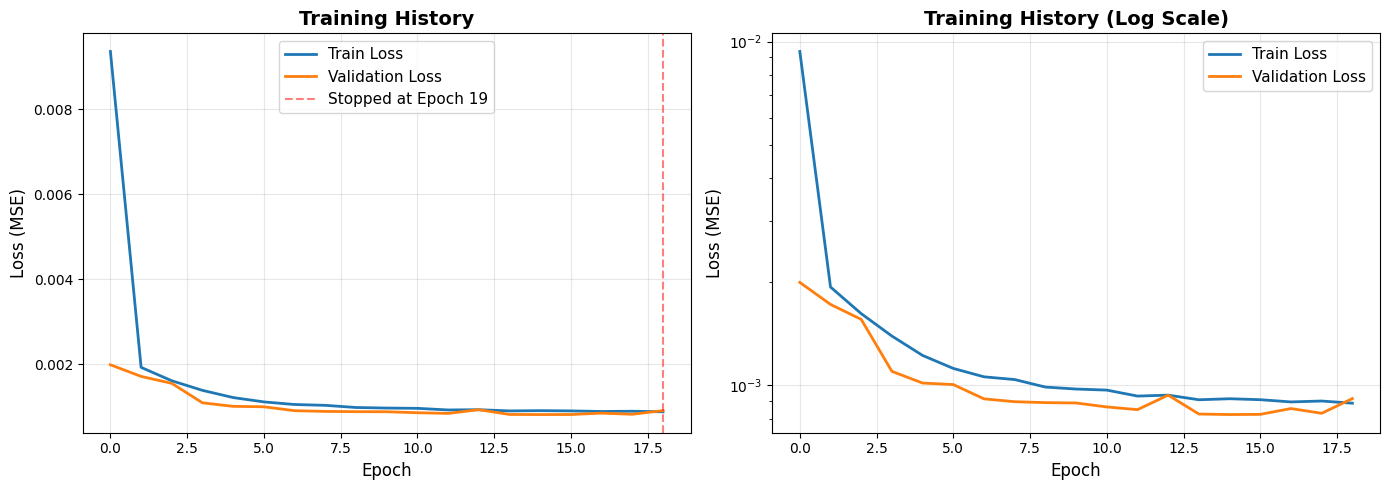

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(len(train_losses)-1, color='red', linestyle='--', alpha=0.5,
           label=f'Stopped at Epoch {len(train_losses)}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Timetable (시간축 예측 결과)

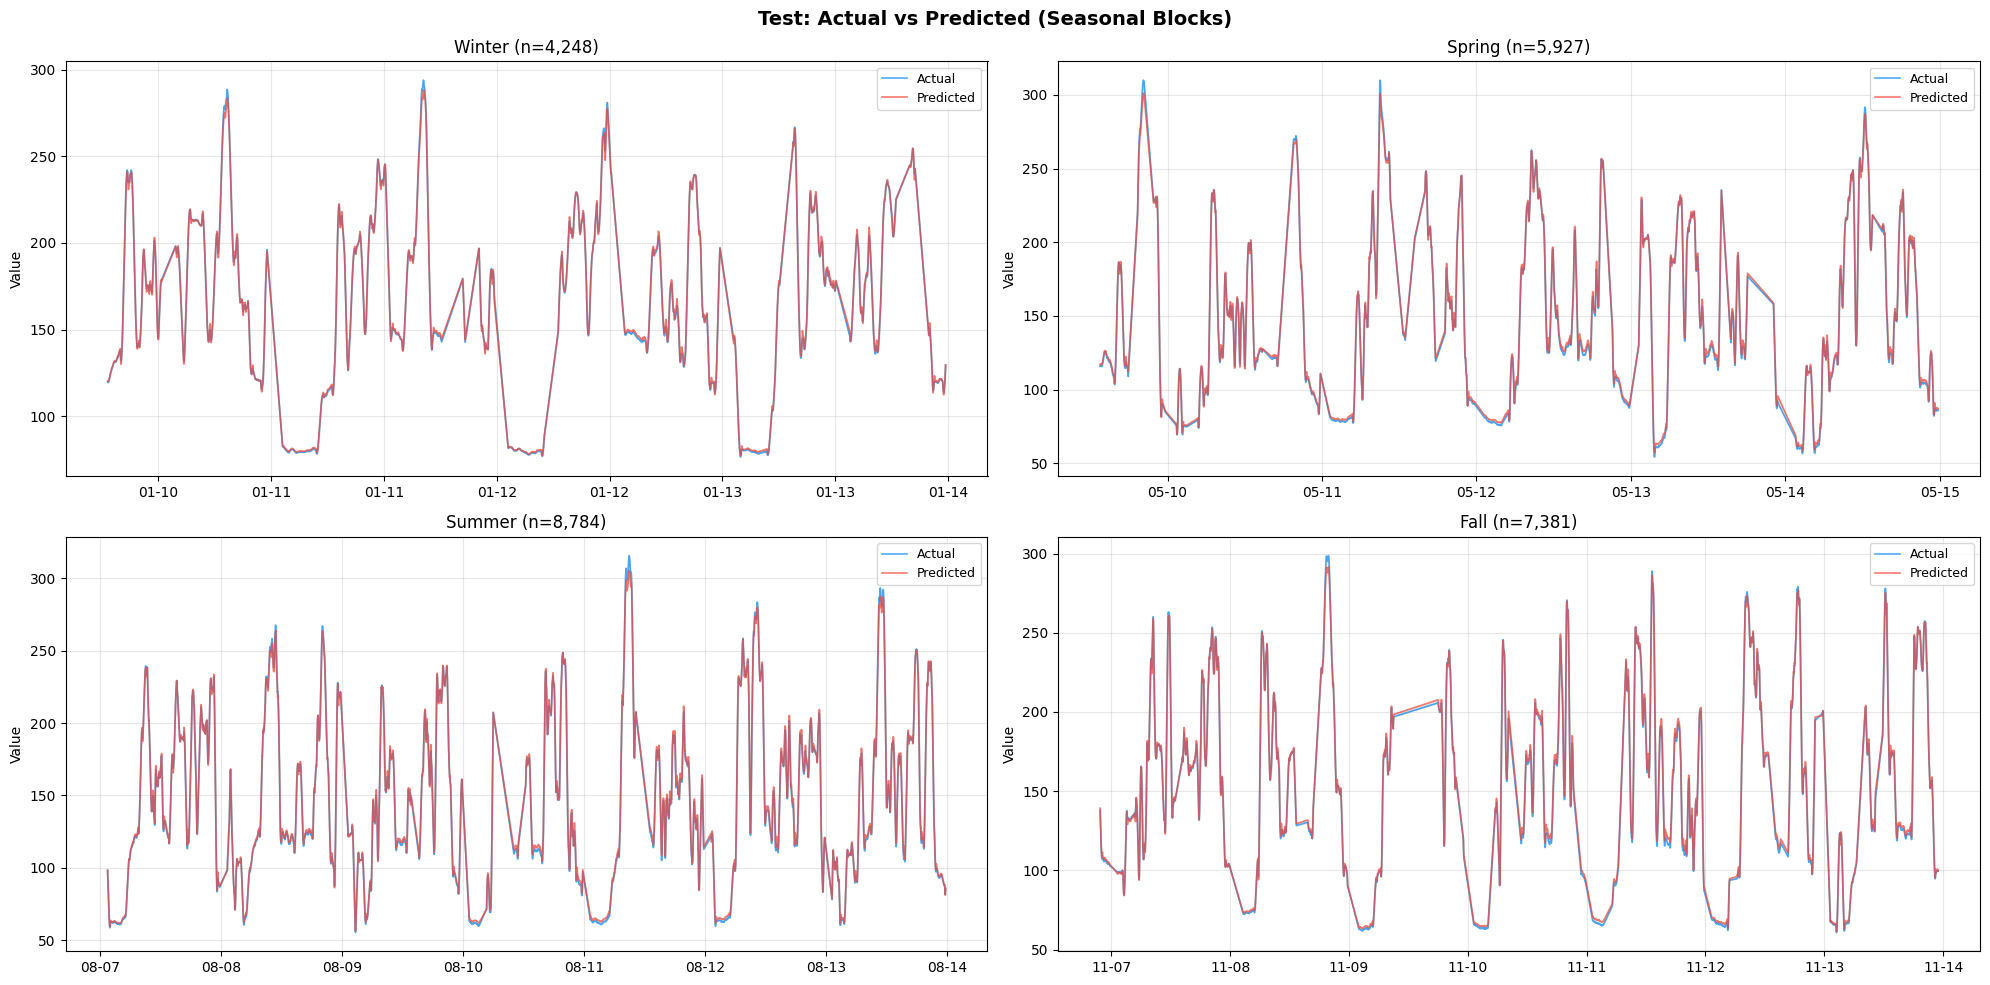

In [25]:
import matplotlib.dates as mdates

actual_series = test_actual_original[:, 0]
pred_series = test_pred_original[:, 0]
plot_times = pd.to_datetime(test_times[:len(actual_series)])

# 2x2 subplot: one per seasonal block
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Test: Actual vs Predicted (Seasonal Blocks)', fontsize=14, fontweight='bold')

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
offset = 0

for ax, name, size in zip(axes.flat, season_names, block_sizes):
    t = plot_times[offset:offset+size]
    a = actual_series[offset:offset+size]
    p = pred_series[offset:offset+size]

    ax.plot(t, a, label='Actual', linewidth=1.2, color='#2196F3', alpha=0.8)
    ax.plot(t, p, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.7)
    ax.fill_between(t, a, p, alpha=0.15, color='gray')
    ax.set_title(f'{name} (n={size:,})', fontsize=12)
    ax.set_ylabel('Value')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    offset += size

plt.tight_layout()
plt.show()


Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)

                    MAPE          RMSE           MAE            R2          Bias
----------------------------------------------------------------------
       All  +0.514%/step  +1.011/step  +0.756/step  -0.00527/step  -0.220/step
    Winter  +0.433%/step  +0.953/step  +0.719/step  -0.00536/step  -0.133/step
    Spring  +0.555%/step  +1.071/step  +0.799/step  -0.00583/step  -0.205/step
    Summer  +0.573%/step  +1.027/step  +0.792/step  -0.00557/step  -0.295/step
      Fall  +0.459%/step  +0.975/step  +0.702/step  -0.00464/step  -0.195/step

             Step 1 MAPE   Step 15 MAPE     Ratio   Step 1 R2   Step 15 R2
----------------------------------------------------------------------
       All        1.14%         8.12%      7.1x      0.9989       0.9239
    Winter        0.66%         6.53%      9.9x      0.9993       0.9231
    Spring        1.30%         8.81%      6.8x      0.9987       0.9160
    Summer        1.23%         9.06%      7.3x

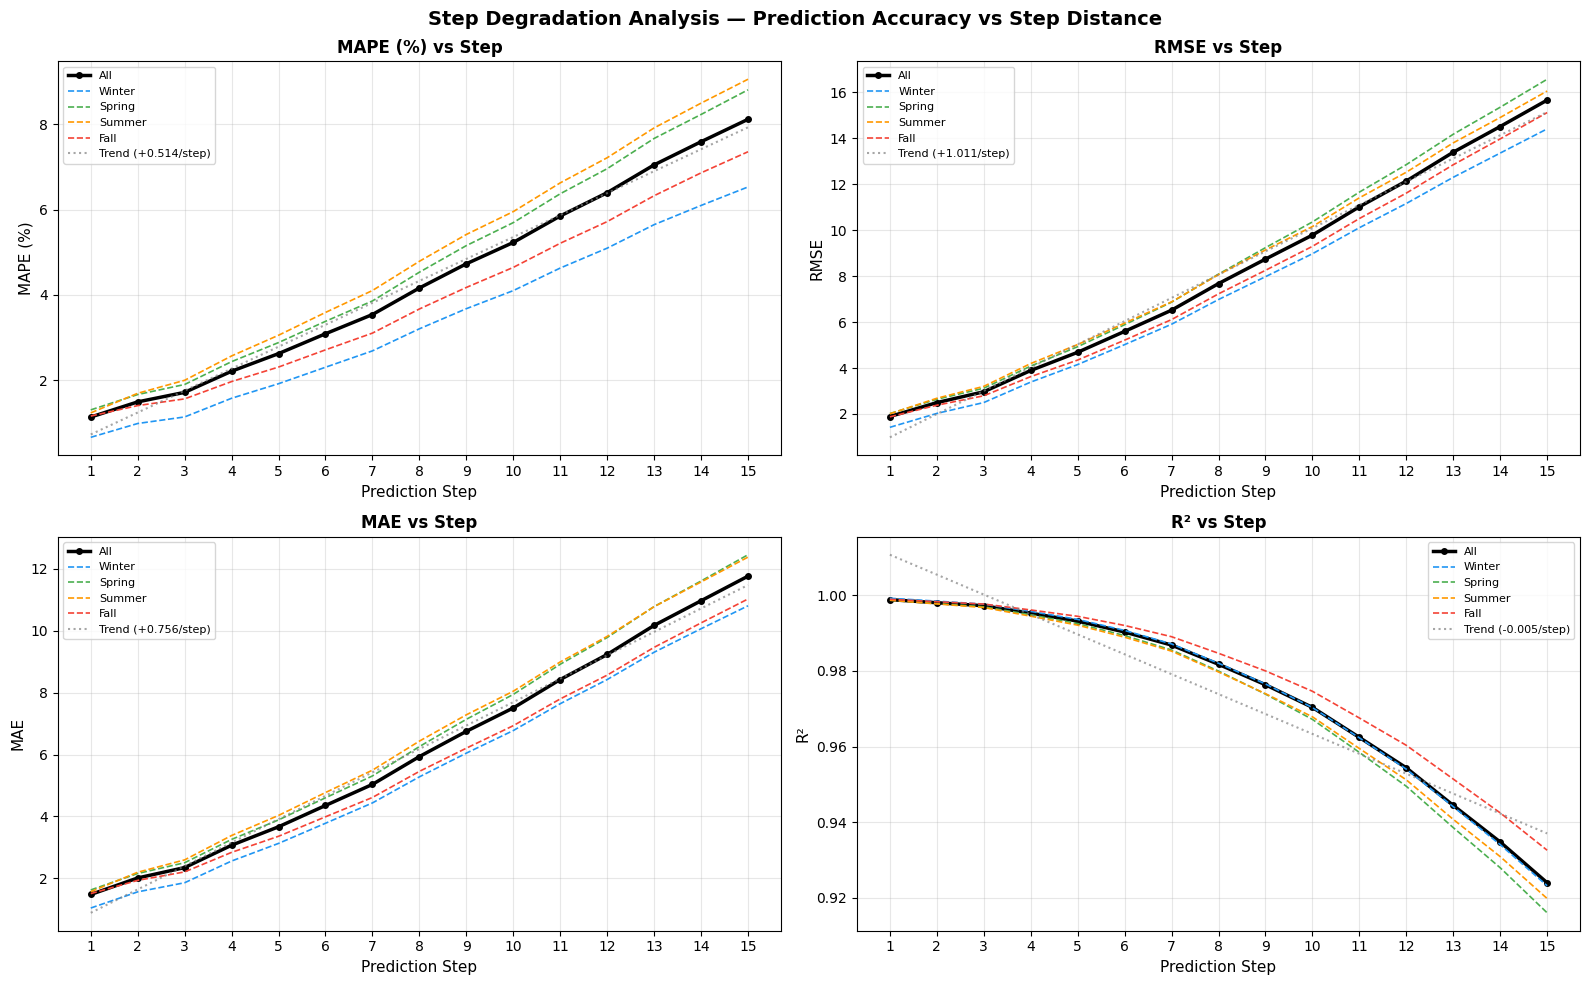


Loss 함수: nn.MSELoss (균등 가중치, Step-weighted 아님)
  Loss: 표준 MSELoss — 모든 Step에 동일 가중치 (1.0)
  Step 1 MAPE: 1.14%
  Step 15 MAPE: 8.12%
  Ratio (Step15/Step1): 7.1x
  MAPE 증가율: 0.499%/step

  해석: 균등 가중치 MSELoss 사용 시 Step 1→15 MAPE가 7.1배 증가.


In [31]:
# Step 증가에 따른 예측 정확도 감소 추세 (전체 + 계절별)
from sklearn.metrics import r2_score as r2_fn

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
steps = np.arange(1, output_time + 1)

# 1) 전체 + 계절별 Step-wise 지표 계산
results = {}  # {name: {metric: [step1, ..., step15]}}

# 전체
all_metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
for s in range(output_time):
    a = test_actual_original[:, s]
    p = test_pred_original[:, s]
    mask = a != 0
    all_metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
    all_metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
    all_metrics['MAE'].append(np.mean(np.abs(a - p)))
    all_metrics['R2'].append(r2_fn(a, p))
    all_metrics['Bias'].append(np.mean(a - p))
results['All'] = all_metrics

# 계절별
offset = 0
for name, size in zip(season_names, block_sizes):
    block_actual = test_actual_original[offset:offset + size]
    block_pred = test_pred_original[offset:offset + size]
    metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
    for s in range(output_time):
        a = block_actual[:, s]
        p = block_pred[:, s]
        mask = a != 0
        metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
        metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
        metrics['MAE'].append(np.mean(np.abs(a - p)))
        metrics['R2'].append(r2_fn(a, p))
        metrics['Bias'].append(np.mean(a - p))
    results[name] = metrics
    offset += size

# 2) 선형 회귀로 감소율(기울기) 계산
from numpy.polynomial.polynomial import polyfit
print("=" * 70)
print("Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)")
print("=" * 70)
print(f"\n{'':>10s}  {'MAPE':>12s}  {'RMSE':>12s}  {'MAE':>12s}  {'R2':>12s}  {'Bias':>12s}")
print("-" * 70)
for name in ['All'] + season_names:
    slopes = {}
    for metric in ['MAPE', 'RMSE', 'MAE', 'R2', 'Bias']:
        b, m = polyfit(steps, results[name][metric], 1)
        slopes[metric] = m
    print(f"{name:>10s}  {slopes['MAPE']:+.3f}%/step  "
          f"{slopes['RMSE']:+.3f}/step  {slopes['MAE']:+.3f}/step  "
          f"{slopes['R2']:+.5f}/step  {slopes['Bias']:+.3f}/step")

# Step 1 vs Step 15 비교
print(f"\n{'':>10s}  {'Step 1 MAPE':>12s}  {'Step 15 MAPE':>13s}  {'Ratio':>8s}  {'Step 1 R2':>10s}  {'Step 15 R2':>11s}")
print("-" * 70)
for name in ['All'] + season_names:
    m1 = results[name]['MAPE'][0]
    m15 = results[name]['MAPE'][-1]
    r1 = results[name]['R2'][0]
    r15 = results[name]['R2'][-1]
    print(f"{name:>10s}  {m1:10.2f}%  {m15:11.2f}%  {m15/m1:7.1f}x  {r1:10.4f}  {r15:11.4f}")

# 3) 시각화: 4개 지표 × (전체 + 계절별)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Step Degradation Analysis — Prediction Accuracy vs Step Distance',
             fontsize=14, fontweight='bold')

colors = {'All': 'black', 'Winter': '#2196F3', 'Spring': '#4CAF50',
          'Summer': '#FF9800', 'Fall': '#F44336'}
linewidths = {'All': 2.5, 'Winter': 1.2, 'Spring': 1.2, 'Summer': 1.2, 'Fall': 1.2}

for ax, metric, ylabel in zip(axes.flat,
    ['MAPE', 'RMSE', 'MAE', 'R2'],
    ['MAPE (%)', 'RMSE', 'MAE', 'R²']):

    for name in ['All'] + season_names:
        vals = results[name][metric]
        ax.plot(steps, vals, label=name, color=colors[name],
                linewidth=linewidths[name],
                linestyle='-' if name == 'All' else '--',
                marker='o' if name == 'All' else None,
                markersize=4)

    # 전체 추세선
    b, m = polyfit(steps, results['All'][metric], 1)
    trend = b + m * steps
    ax.plot(steps, trend, color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'Trend ({m:+.3f}/step)')

    ax.set_xlabel('Prediction Step', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'{ylabel} vs Step', fontsize=12, fontweight='bold')
    ax.set_xticks(steps)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Loss 함수 분석 (이 모델은 표준 MSELoss — 균등 가중치)
print("\n" + "=" * 70)
print("Loss 함수: nn.MSELoss (균등 가중치, Step-weighted 아님)")
print("=" * 70)
print(f"  Loss: 표준 MSELoss — 모든 Step에 동일 가중치 (1.0)")
print(f"  Step 1 MAPE: {results['All']['MAPE'][0]:.2f}%")
print(f"  Step 15 MAPE: {results['All']['MAPE'][-1]:.2f}%")
print(f"  Ratio (Step15/Step1): {results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}x")
print(f"  MAPE 증가율: {(results['All']['MAPE'][-1]-results['All']['MAPE'][0])/(output_time-1):.3f}%/step")
print(f"\n  해석: 균등 가중치 MSELoss 사용 시 Step 1→15 MAPE가 "
      f"{results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}배 증가.")

- Final Summary & 모델 저장

In [32]:
test_ratio = 1 - train_ratio - val_ratio

print("\n" + "="*60)
print("Final Summary (Multi-Feature LSTM)")
print("="*60)
print(f"Features: {feature_cols}")
print(f"Data: {len(df_merged):,}행 (seasonal block sampling)")
print(f"Data Split: Train {train_ratio*100:.0f}% / Val {val_ratio*100:.0f}% / Test {test_ratio*100:.0f}%")
print(f"Stopped at Epoch: {len(train_losses)}")
print(f"Best Val Loss: {early_stopping.best_loss:.6f}")
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R²: {test_r2:.4f}")
print(f"Mean Error (Bias): {np.mean(test_actual_original - test_pred_original):.4f}")
print("="*60)


Final Summary (Multi-Feature LSTM)
Features: ['value', 'temperature', 'rainfall', 'humidity', 'time_sin', 'time_cos', 'dow_sin', 'dow_cos', 'season_sin', 'season_cos']
Data: 228,825행 (seasonal block sampling)
Data Split: Train 70% / Val 15% / Test 15%
Stopped at Epoch: 19
Best Val Loss: 0.000825
Test Loss: 0.000859
Test RMSE: 9.1784
Test MAE: 6.1817
Test MAPE: 4.33%
Test R²: 0.9739
Mean Error (Bias): -2.7519


In [33]:
model_path = BASE_DIR / "models" / "lstm_weather_time.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scalers': {col: {'min': scalers[col].data_min_[0], 'max': scalers[col].data_max_[0]} for col in scale_cols},
    'feature_cols': feature_cols,
    'scale_cols': scale_cols,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': avg_test_loss,
    'best_epoch': len(train_losses),
    'input_time': input_time,
    'output_time': output_time,
}, model_path)

print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /home/kp/web/work/pro/models/lstm_weather_time.pth
